In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
seed = 1
model = "gptneo1B"
lr = 'lr2e5'

with open(f"SOME_DATA_DIR/nrep_aucs_{model}_exactduplicates{model_suffix}_seed{seed}_{lr}.pickle", "rb") as f:
   nrep_aucs = pickle.load(f)

In [3]:
def compute_rho(phi_fuz: float, phi_exact: dict, n_extrapol_large=3):
    '''
    n_extrapol_large: the number of largest exact duplicates to use for extrapolation beyond max
                      if 1, this can be quite sensitive to noise, so default is 3
    '''

    lambda_ = None
    max_key = max(phi_exact.keys())
    
    # first if the target is smaller than the smallest for exact
    if phi_fuz <= phi_exact[1]:
        lambda_ = 1
        neq = lambda_ + (phi_fuz - phi_exact[lambda_]) / (phi_exact[lambda_+1] - phi_exact[lambda_])
        neq = max(1.0, neq)
    
    # then if the target is larger than the largest for exact, extrapolate
    elif phi_fuz >= phi_exact[max_key]:
        
        n0 = max_key - n_extrapol_large
        slope = np.mean([np.abs(phi_exact[i + 1] - phi_exact[i]) for i in range(n0, max_key)])
        neq = max_key + (phi_fuz - phi_exact[max_key]) / slope 
        
        #lambda_ = max_key
        #neq = lambda_ + (phi_fuz - phi_exact[lambda_]) / (phi_exact[lambda_] - phi_exact[lambda_ - 1])
    
    # do interpolation otherwise
    else:
        for n in range(1, max_key):
            if phi_exact[n] <= phi_fuz and phi_exact[n+1] >= phi_fuz:
                lambda_ = n
        neq = lambda_ + (phi_fuz - phi_exact[lambda_]) / (phi_exact[lambda_ + 1] - phi_exact[lambda_])
    
    # return the normalized value (assuming n_dup=10)
    return (neq - 1) / 9.0
  
def smooth_curve(nrep_aucs, mia = 'ratio', window_size=3):
    
    original_values =  [np.mean(nrep_aucs[n][mia]) for n in range(1, max(nrep_aucs.keys()) + 1)]

    # Apply a moving average with a window of 3
    smoothed_values = np.convolve(original_values, np.ones(window_size) / window_size, mode='valid')

    # Extend smoothed values to match original length
    smoothed_values = np.concatenate(([original_values[0]], smoothed_values, [original_values[-1]]))
        
    return {n:smoothed_values[i] for i, n in enumerate(range(1,max(nrep_aucs.keys())+1))}

## Let's first get the smoothed curve

In [4]:
all_mias = ('loss', 'ratio', 'lowercase', 'minkprob', 'zlib')

all_phi_exact = dict()

for mia in all_mias:
    all_phi_exact[mia] = smooth_curve(nrep_aucs, mia=mia, window_size=3)

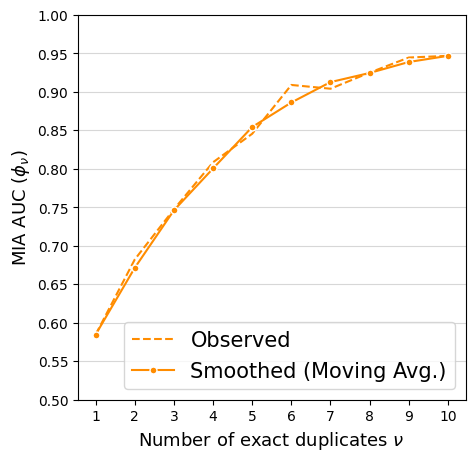

In [ ]:
mia = 'ratio'

ns = np.arange(1, 11)  # Number of exact duplicates
observed = [np.mean(nrep_aucs[n][mia]) for n in range(1,max(nrep_aucs.keys())+1)]
smoothed = smooth_curve(nrep_aucs, mia=mia, window_size=3).values()

plt.figure(figsize=(5, 5))
plt.plot(ns, observed, label='Observed', linestyle='--', color = 'darkorange')
plt.plot(ns, smoothed, '-o', label='Smoothed (Moving Avg.)', color = 'darkorange', 
         markersize=5, markeredgecolor='white', markerfacecolor='darkorange', markeredgewidth=1)

plt.xlabel(r"Number of exact duplicates $\nu$", fontsize = 13)
plt.ylabel(r"MIA AUC ($\phi_{\nu}$)", fontsize = 13)
plt.xticks(ns)
plt.yticks(np.linspace(0.5, 1.00, 11))
plt.ylim(0.5, 1.00)
plt.legend(fontsize = 15, loc='lower right')
plt.grid(axis='y', alpha=0.5)
plt.show()


In [7]:
all_Rs = [1, 5, 10, 15, 20, 25, 50, 75]

In [ ]:
seed = 1
model = "gptneo1B"
lr = 'lr2e5'

with open(f"SOME_DATA_DIR/nrep_aucs_{model}_exactduplicates_seed{seed}_{lr}.pickle", "rb") as f:
   nrep_aucs = pickle.load(f)
       
# then smooth this
all_phi_exact = smooth_curve(nrep_aucs, mia=mia, window_size=3)
    
# then get the near dupls
with open(f"SOME_DATA_DIR/R_aucs_gptneo1B_nearduplicates_diffindices_topk10_RXX_seed{seed}_lr2e5.pickle" , "rb") as f:
   R_aucs = pickle.load(f)
    
rho_to_plot = dict()
for R in all_Rs:
    rho_to_plot[R] = compute_rho(phi_fuz=R_aucs[R][mia], phi_exact=all_phi_exact)

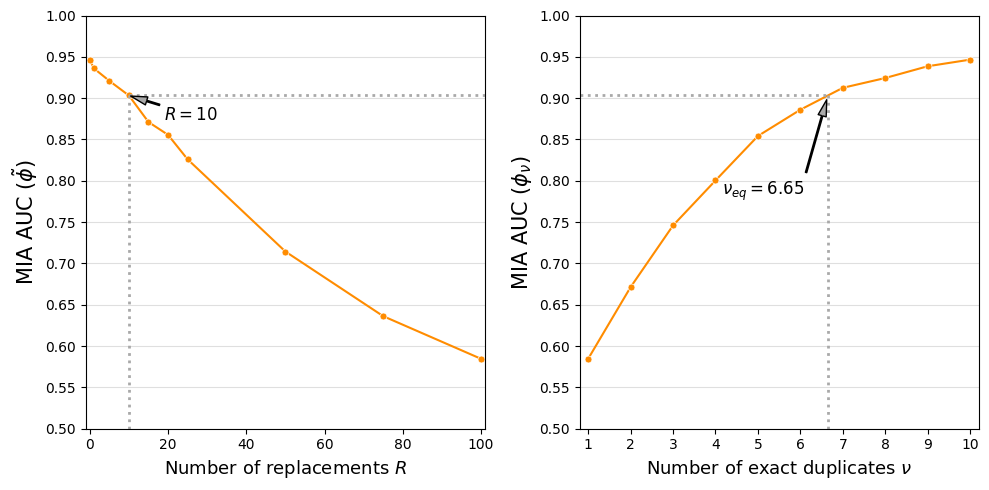

In [ ]:
all_ns = range(1, 11)

# Set the reference R value to link between the two plots
mia = 'ratio'
R_value = 10  # You can change this
R_auc_value = R_aucs[R_value][mia]  # The AUC at R=10

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# ---------- Left plot (R vs AUC) ----------
ax1.plot([0] + all_Rs + [100], [nrep_aucs[10][mia]] + [R_aucs[R][mia] for R in all_Rs] + [nrep_aucs[1][mia]],
         '-o', color='darkorange', markersize=5, markeredgecolor='white', markerfacecolor='darkorange', markeredgewidth=0.5)

ax1.set_xlabel(r'Number of replacements $R$', fontsize=13)
ax1.set_ylabel(r"MIA AUC ($\tilde{\phi}$)", fontsize=15)
ax1.grid(axis='y', alpha = 0.4)
ax1.set_ylim(0.5, 1)
ax1.set_yticks([0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1])
ax1.set_xlim(-1, 101)

# Vertical dotted line at R=R_value and horizontal dotted line at the AUC value
#ax1.axvline(R_value, linestyle='dotted', color='red', linewidth=2)
ax1.plot([R_value, R_value], [0.5, R_auc_value], linestyle='dotted', color='darkgrey', linewidth=2)
ax1.plot([R_value, 101], [R_auc_value, R_auc_value], linestyle='dotted', color='darkgrey', linewidth=2)

# ---------- Right plot (n_dup vs AUC) ----------
ax2.plot(all_ns, [all_phi_exact[n] for n in all_ns], '-o', color='darkorange', markersize=5,
         markeredgecolor='white', markerfacecolor='darkorange', markeredgewidth=0.5)

ax2.set_xlabel(r"Number of exact duplicates $\nu$", fontsize=13)
ax2.set_ylabel(r"MIA AUC ($\phi_{\nu}$)", fontsize=15)
ax2.grid(axis='y', alpha = 0.4)
ax2.set_ylim(0.5, 1)
ax2.set_xlim(0.8, 10.2)
ax2.set_yticks([0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1])
ax2.set_xticks(all_ns)

# Find the closest value of n_dup where the horizontal line intersects the Ratio AUC curve in the right plot
n_eq = rho_to_plot[R_value] * 9 + 1
n_dup_auc_value = R_auc_value

# Horizontal dotted line from left to right plot at AUC value
ax2.plot([0.8, n_eq], [R_auc_value, R_auc_value], linestyle='dotted', color='darkgrey', linewidth=2)

# Vertical dotted line at the corresponding n_dup value
ax2.plot([n_eq, n_eq], [0.5, R_auc_value], linestyle='dotted', color='darkgrey', linewidth=2)

# Annotating the vertical connections
ax1.annotate(f'$R={R_value}$', xy=(R_value, R_auc_value), xytext=(R_value + 9, R_auc_value - 0.03),
             fontsize=12, arrowprops=dict(facecolor='darkgrey', shrink=0.05, width=1, headwidth=6))
ax2.annotate(rf'$\nu_{{eq}}={n_eq:.2f}$', xy=(n_eq, R_auc_value), xytext=(n_eq - 2.5, R_auc_value - 0.12),
             fontsize=12, arrowprops=dict(facecolor='darkgrey', shrink=0.05, width=1, headwidth=6))

# Adjust the layout
plt.tight_layout()
plt.show()


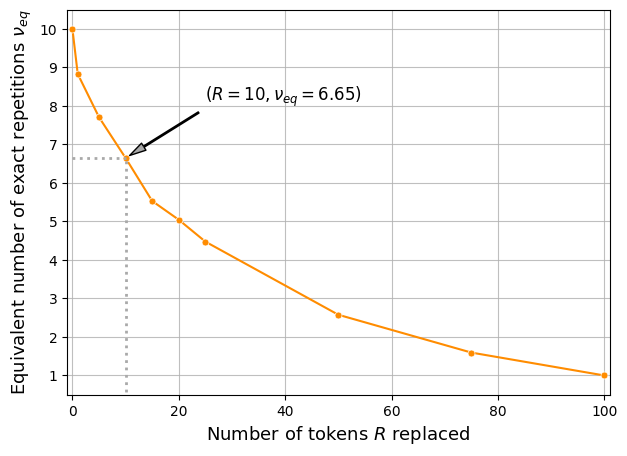

In [ ]:
# Let's now plot the equivalent number of repetitions
    
plt.figure(figsize = (7, 5))

plt.plot([0] + all_Rs + [100], [10] + [rho_to_plot[R] * 9 + 1 for R in all_Rs] + [1], '-o', color='darkorange', markersize=5,
                markeredgecolor='white', markerfacecolor='darkorange', markeredgewidth=0.5)

# Horizontal dotted line from left to right plot at AUC value
plt.plot([0, R_value], [n_eq, n_eq], linestyle='dotted', color='darkgrey', linewidth=2)

# Vertical dotted line at the corresponding n_dup value
plt.plot([R_value, R_value], [0, n_eq], linestyle='dotted', color='darkgrey', linewidth=2)

# Annotating the vertical connections
plt.annotate(rf'($R={R_value}, \nu_{{eq}}={n_eq:.2f})$', xy=(R_value, n_eq), xytext=(R_value + 15, n_eq + 1.5),
             fontsize=12, arrowprops=dict(facecolor='darkgrey', shrink=0.05, width=1, headwidth=6))

plt.xlabel(r'Number of tokens $R$ replaced', fontsize = 13)
plt.ylabel(r"Equivalent number of exact repetitions $\nu_{{eq}}$", fontsize = 13)
plt.grid(alpha = 0.8)
plt.ylim(0.5, 10.5)
plt.yticks([k for k in range(1, 11)])
plt.xlim(-1, 101)
plt.show()

## For all models

Processing model: gptneo1B
0.8977 ± 0.0314
0.7811 ± 0.0225
0.6462 ± 0.0209
0.5202 ± 0.0363
0.4519 ± 0.0376
0.4014 ± 0.0176
0.1864 ± 0.0115
0.0810 ± 0.0128
Processing model: gemma2B
0.9345 ± 0.1049
0.7628 ± 0.0197
0.6039 ± 0.0202
0.4811 ± 0.0453
0.3935 ± 0.0224
0.3218 ± 0.0238
0.1353 ± 0.0191
0.0615 ± 0.0224
Processing model: llama_3.2_1B
0.9025 ± 0.0739
0.7570 ± 0.0166
0.6340 ± 0.0250
0.4906 ± 0.0311
0.3986 ± 0.0260
0.3276 ± 0.0156
0.1347 ± 0.0215
0.0641 ± 0.0113
Processing model: phi2
0.9188 ± 0.0375
0.7766 ± 0.1530
0.6330 ± 0.1028
0.5425 ± 0.1323
0.4626 ± 0.0417
0.3800 ± 0.0479
0.1731 ± 0.0348
0.0576 ± 0.0190


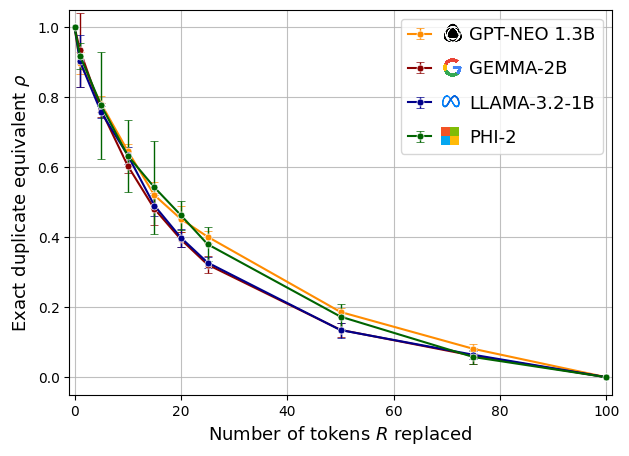

In [ ]:
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.legend_handler import HandlerBase, HandlerTuple, HandlerErrorbar
from matplotlib.lines import Line2D
from matplotlib.container import ErrorbarContainer

# let's now do it for all the seeds

model_to_seeds = {
    'gptneo1B': (1, 2, 3, 4, 5),
    'llama_3.2_1B': (1, 2, 3, 4, 5),
    'phi2': (1, 2, 3, 4, 5),
    'gemma2B': (1, 2, 3, 4, 5)
}

all_Rs = [1, 5, 10, 15, 20, 25, 50, 75]

mia = 'ratio'

colors = ('darkorange', 'darkred', 'darkblue', "darkgreen")
models = ('gptneo1B', 'gemma2B', "llama_3.2_1B", "phi2")
model_suffixes = ('_gpt', '_gemma', '_llama', '_phi')
lrs = ('lr2e5', 'lr3e5', 'lr2e5', 'lr6e5')
labels = ('GPT-NEO 1.3B', 'GEMMA-2B', "LLAMA-3.2-1B", "PHI-2")

plt.figure(figsize=(7, 5))

errorbar_handles = []  # store the actual handles returned by plt.errorbar

for i, model in enumerate(models):
    
    print(f"Processing model: {model}")

    all_rhos = {R: [] for R in all_Rs}

    for seed in model_to_seeds[model]:
        results_path = f"SOME_DATA_DIR/R_aucs_{model}_nearduplicates_diffindices_topk10{model_suffixes[i]}_RXX_seed{seed}_{lrs[i]}.pickle"
        with open(results_path, "rb") as f:
            R_aucs = pickle.load(f)

        exact_path = f"SOME_DATA_DIR/nrep_aucs_{model}_exactduplicates{model_suffixes[i]}_seed{seed}_{lrs[i]}.pickle"
        with open(exact_path, "rb") as f:
            nrep_aucs = pickle.load(f)

        all_phi_exact = smooth_curve(nrep_aucs, mia=mia, window_size=3)

        for R in all_Rs:
            all_rhos[R].append(compute_rho(phi_fuz=R_aucs[R][mia], phi_exact=all_phi_exact))

    mean_rhos = [np.mean(all_rhos[R]) for R in all_Rs]
    for R in all_Rs:
        print(f"{np.mean(all_rhos[R]):.4f} ± {np.std(all_rhos[R]):.4f}")
    std_rhos = [np.std(all_rhos[R]) for R in all_Rs]

    # capture the handle from plt.errorbar
    h = plt.errorbar(
        [0] + all_Rs + [100],
        [1] + mean_rhos + [0],
        yerr=[0] + std_rhos + [0],
        fmt='-o',
        color=colors[i],
        markersize=5,
        markeredgecolor='white',
        markerfacecolor=colors[i],
        markeredgewidth=0.5,
        capsize=3,
        capthick=1,
        elinewidth=1,
    )
    
    errorbar_handles.append(h)  # keep the handle for legend use

plt.xlabel(r'Number of tokens $R$ replaced', fontsize=13)
plt.ylabel(r"Exact duplicate equivalent $\rho$", fontsize=13)
plt.grid(alpha=0.8)
plt.ylim(-0.05, 1.05)
plt.xlim(-1, 101)

# 1) Map each model to a logo path
logo_paths = {
    'gptneo1B': 'SOME_DATA_DIR/Eleuther-logo.png',
    'gemma2B': 'SOME_DATA_DIR/Google-logo.png',
    'llama_3.2_1B': 'SOME_DATA_DIR/Meta-logo.png',
    'phi2': 'SOME_DATA_DIR/Microsoft-logo.png',
}

logo_to_size = {
    'gptneo1B': 11,
    'gemma2B': 1.2,
    'llama_3.2_1B': 16,
    'phi2': 0.5,
}

# Custom handler for images (slightly better centering)
class HandlerImage(HandlerBase):
    def __init__(self, path, size_px=18):
        super().__init__()
        self.arr = mpimg.imread(path)
        self.size_px = size_px

    def create_artists(self, legend, orig_handle, xdescent, ydescent,
                       width, height, fontsize, trans):
        zoom = self.size_px / 72.0
        im = OffsetImage(self.arr, zoom=zoom)
        # slightly left-align image to balance spacing visually
        ab = AnnotationBbox(
            im,
            (0.05 * width - xdescent, height / 2 - ydescent),
            frameon=False,
            box_alignment=(0, 0.5),
            xycoords=trans,
        )
        return [ab]

# Build the dummy logo handles
logo_handles = [object() for _ in models]
legend_labels = list(labels)

# Combine actual errorbar (marker+error) first, then logo
combined_handles = [(errorbar_handles[i], logo_handles[i]) for i in range(len(models))]

# Handler map: use real errorbar and image handlers
handler_map = {tuple: HandlerTuple(ndivide=None), ErrorbarContainer: HandlerErrorbar(xerr_size=0, yerr_size=0.3)} # do 0.3 yerr to make it for std
for i, model in enumerate(models):
    handler_map[logo_handles[i]] = HandlerImage(logo_paths[model], size_px=logo_to_size[model])

# Create legend (same style, just better marker + spacing)
plt.legend(
    combined_handles,
    legend_labels,
    handler_map=handler_map,
    fontsize=13,
    loc='upper right',
    handlelength=3,   
    handletextpad=0.4,
    borderpad=0.4,
    labelspacing=0.9,
    frameon=True,
)


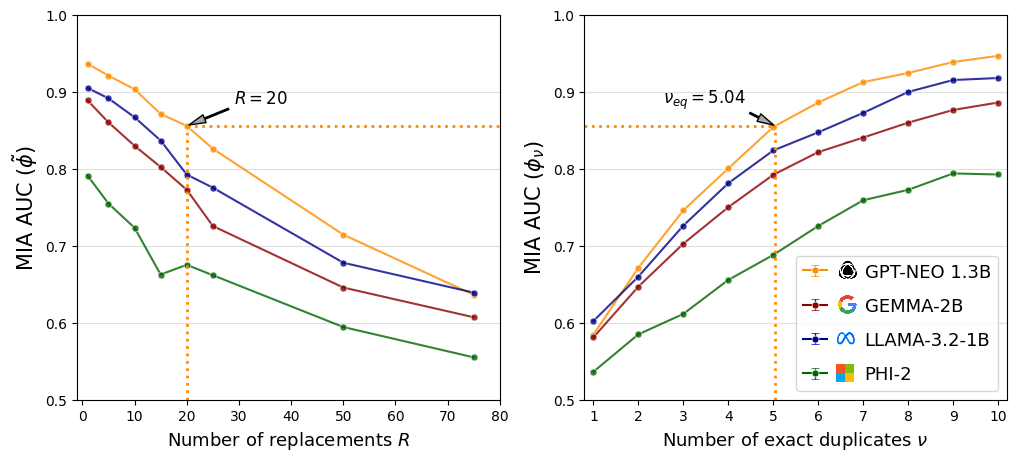

In [ ]:
all_ns = range(1, 11)

# Set the reference R value to link between the two plots
mia = 'ratio'
colors = ('darkorange', 'darkred', 'darkblue', "darkgreen")
models = ('gptneo1B', 'gemma2B', "llama_3.2_1B", "phi2")
model_suffixes = ('_gpt', '_gemma', '_llama', '_phi')
lrs = ('lr2e5', 'lr3e5', 'lr2e5', 'lr6e5')
labels = ('GPT-NEO 1.3B', 'GEMMA-2B', "LLAMA-3.2-1B", "PHI-2")

model_to_seeds = {
    'gptneo1B': (1,),
    'llama_3.2_1B': (5,),
    'phi2': (1,),
    'gemma2B': (5,)
}

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

for i, model in enumerate(models):
    for seed in model_to_seeds[model]:

        # first load the near dupls
        results_path = f"SOME_DATA_DIR/R_aucs_{model}_nearduplicates_diffindices_topk10{model_suffixes[i]}_RXX_seed{seed}_{lrs[i]}.pickle"
        with open(results_path, "rb") as f:
            R_aucs = pickle.load(f)
        
        ax1.plot(all_Rs, [R_aucs[R][mia] for R in all_Rs], '-o', alpha = 0.8, 
                 color=colors[i], markersize=5, markeredgecolor='white', markerfacecolor=colors[i], markeredgewidth=0.5)

ax1.set_xlabel(r'Number of replacements $R$', fontsize=13)
ax1.set_ylabel(r"MIA AUC ($\tilde{\phi}$)", fontsize=15)
ax1.grid(axis='y', alpha = 0.4)
ax1.set_ylim(0.5, 1)
ax1.set_yticks([0.5, 0.6, 0.7, 0.8, 0.9, 1])
ax1.set_xlim(-1, 80)

for i, model in enumerate(models):
    for seed in model_to_seeds[model]:
        
        exact_path = f"SOME_DATA_DIR/nrep_aucs_{model}_exactduplicates{model_suffixes[i]}_seed{seed}_{lrs[i]}.pickle"
        with open(exact_path, "rb") as f:
            nrep_aucs = pickle.load(f)
           
        # then smooth this
        all_phi_exact = smooth_curve(nrep_aucs, mia=mia, window_size=3)

        ax2.plot(all_ns, [all_phi_exact[n] for n in all_ns], '-o', color=colors[i], markersize=5, alpha = 0.8,
            markeredgecolor='white', markerfacecolor=colors[i], markeredgewidth=0.5)
        
# let's also annotate
R_value = 20  
model, model_suffix, lr, seed = models[0], model_suffixes[0], lrs[0], 1
results_path = f"SOME_DATA_DIR/R_aucs_{model}_nearduplicates_diffindices_topk10{model_suffix}_RXX_seed{seed}_{lr}.pickle"
with open(results_path, "rb") as f:
    R_aucs = pickle.load(f)
R_auc_value = R_aucs[R_value][mia] 

ax1.plot([R_value, R_value], [0.5, R_auc_value], linestyle='dotted', color='darkorange', linewidth=2)
ax1.plot([R_value, 101], [R_auc_value, R_auc_value], linestyle='dotted', color='darkorange', linewidth=2)

# Find the closest value of n_dup where the horizontal line intersects the Ratio AUC curve in the right plot
n_eq = rho_to_plot[R_value] * 9 + 1
n_dup_auc_value = R_auc_value

# Horizontal dotted line from left to right plot at AUC value
ax2.plot([0.8, n_eq], [R_auc_value, R_auc_value], linestyle='dotted', color='darkorange', linewidth=2)

# Vertical dotted line at the corresponding n_dup value
ax2.plot([n_eq, n_eq], [0.5, R_auc_value], linestyle='dotted', color='darkorange', linewidth=2)

# Annotating the vertical connections
ax1.annotate(f'$R={R_value}$', xy=(R_value, R_auc_value), xytext=(R_value + 9, R_auc_value + 0.03),
             fontsize=12, arrowprops=dict(facecolor='darkgrey', shrink=0.05, width=1, headwidth=6))
ax2.annotate(rf'$\nu_{{eq}}={n_eq:.2f}$', xy=(n_eq, R_auc_value), xytext=(n_eq - 2.5, R_auc_value + 0.03),
             fontsize=12, arrowprops=dict(facecolor='darkgrey', shrink=0.05, width=1, headwidth=6))

ax2.set_xlabel(r"Number of exact duplicates $\nu$", fontsize=13)
ax2.set_ylabel(r"MIA AUC ($\phi_{\nu}$)", fontsize=15)
ax2.grid(axis='y', alpha = 0.4)
ax2.set_ylim(0.5, 1)
ax2.set_xlim(0.8, 10.2)
ax2.set_xticks(all_ns)

ax2.legend(
    combined_handles,
    legend_labels,
    handler_map=handler_map,
    fontsize=13,
    loc='lower right',
    handlelength=3,   
    handletextpad=0.4,
    borderpad=0.4,
    labelspacing=0.9,
    frameon=True,
)

plt.show()
